In [477]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [478]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
# d = [[1, 2], [3, 4], [5, 6]]
# n = 2   # 两个设施点
# m = 3   # 三个需求点
num_qubits = n +  n * m

# gi设施i的建设成本
g = [2, 1]


In [479]:
penalty = 25
depth = 3
params = np.ones(depth * 2)

In [480]:
# dtype=np.complex128
def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H


def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(m):
        for j in range(n):
            Hp += d[i][j] * (add_in_target(num_qubits, n * (1 + i) + j) - np.eye(2**num_qubits)) / 2
    
    for j in range(n):
        Hp +=  g[j - 1] * (add_in_target(num_qubits, j)- np.eye(2**num_qubits)) / 2

    return Hp

In [481]:
GateX = np.array([[0, 1],[1, 0]])
GateY = np.array([[0, -1j],[1j, 0]])
GateZ = np.array([[1, 0],[0, -1]])

def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H
def generate_H():
    Hp = np.zeros((2**6, 2**6))
    for i in range(6):
        Hp +=  add_in_target(6, i, GateX)
    return Hp
# 求解本征值和本征态
eigenvalues, eigenvectors = np.linalg.eig(generate_H())
print(eigenvalues)
# 输出结果
for i in range(len(eigenvalues)):
  print("\nEigenvalues:")
  print(f'{eigenvalues[i].real:.4f}')
  print("Eigenvectors:")
  print([f'{num:.4f}' for num in eigenvectors[:, i].real])

[-6.00000000e+00+0.00000000e+00j  6.00000000e+00+0.00000000e+00j
  7.00096553e-16+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
  4.00000000e+00+0.00000000e+00j -2.68500586e-16+5.92456414e-17j
 -2.68500586e-16-5.92456414e-17j  4.00000000e+00+0.00000000e+00j
  4.00000000e+00+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
 -4.10258332e-17+1.36293347e-16j -4.10258332e-17-1.36293347e-16j
 -4.00000000e+00+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j  1.91119105e-17+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -1.38691508e-16+0.00000000e+00j
  3.00994557e-16+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.000000

In [482]:
from scipy.linalg import expm
def build_circ(n, m, d, g, params):
  qc = QuantumCircuit(num_qubits)
  beta = params[:depth + 1]
  gamma = params[depth:]
  # for i in range(num_qubits):
  #   qc.h(i)
  #   qc.z(i)
  qc.initialize(eigenvectors[:, 0].real, range(6))
  for dp in range(depth):
    qc.unitary(expm(-1j * gamma[dp] * generate_Hp(n, m, d, g)), range(num_qubits))
    for i in range(num_qubits):
      qc.rx(beta[dp], i)
  qc.measure_all()
  return qc

In [483]:
def cost_function(x):
  num = [int(char) for char in x]
  C = 0
  for i in range(m):
    for j in range(n):
      C += d[i][j] * num[n * (1 + i) + j]
      
  for j in range(n):
    C += g[j] * num[j]

  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(n, m, d, g, theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [484]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample()

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 设定最大迭代次数
max_iterations = 1000

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)

Iteration 10, Result: 0.753


Iteration 20, Result: 0.6045
Iteration 30, Result: 0.522
Iteration 40, Result: 0.522
Iteration 50, Result: 0.518
Iteration 60, Result: 0.5155
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5155
       x: [ 1.163e+00  2.912e+00  6.936e-01  7.636e-01  5.057e-01
            9.191e-02]
    nfev: 64
   maxcv: 0.0


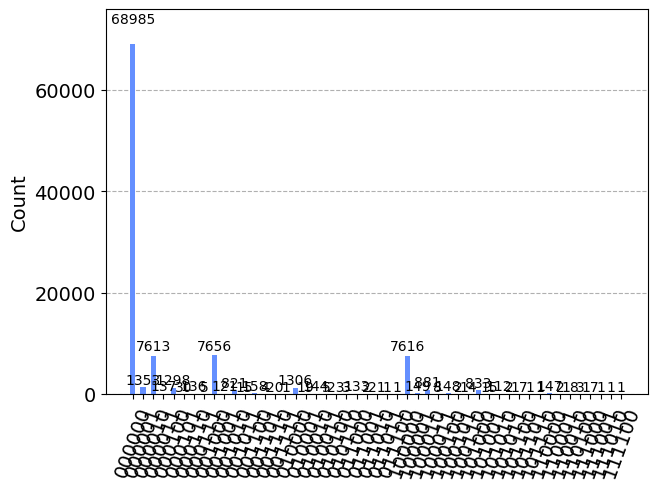

In [485]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

shots=100000
qc_res = build_circ(n, m, d, g, params=res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = shots).result().get_counts()
plot_histogram(counts)

In [486]:
qc_res.draw()

┌───┐┌───┐┌──────────┐┌───────────┐┌──────────┐┌────────────┐»
   q_0: ┤ H ├┤ Z ├┤0         ├┤ Rx(1.163) ├┤0         ├┤ Rx(2.9117) ├»
        ├───┤├───┤│          │├───────────┤│          │├────────────┤»
   q_1: ┤ H ├┤ Z ├┤1         ├┤ Rx(1.163) ├┤1         ├┤ Rx(2.9117) ├»
        ├───┤├───┤│          │├───────────┤│          │├────────────┤»
   q_2: ┤ H ├┤ Z ├┤2         ├┤ Rx(1.163) ├┤2         ├┤ Rx(2.9117) ├»
        ├───┤├───┤│  Unitary │├───────────┤│  Unitary │├────────────┤»
   q_3: ┤ H ├┤ Z ├┤3         ├┤ Rx(1.163) ├┤3         ├┤ Rx(2.9117) ├»
        ├───┤├───┤│          │├───────────┤│          │├────────────┤»
   q_4: ┤ H ├┤ Z ├┤4         ├┤ Rx(1.163) ├┤4         ├┤ Rx(2.9117) ├»
        ├───┤├───┤│          │├───────────┤│          │├────────────┤»
   q_5: ┤ H ├┤ Z ├┤5         ├┤ Rx(1.163) ├┤5         ├┤ Rx(2.9117) ├»
        └───┘└───┘└──────────┘└───────────┘└──────────┘└────────────┘»
meas: 6/═════════════════════════════════════════════════════════════»
                                                                     »
«        ┌──────────┐┌─────────────┐ ░ ┌─┐               
«   q_0: ┤0         ├┤ Rx(0.69363) ├─░─┤M├───────────────
«        │          │├─────────────┤ ░ └╥┘┌─┐            
«   q_1: ┤1         ├┤ Rx(0.69363) ├─░──╫─┤M├────────────
«        │          │├─────────────┤ ░  ║ └╥┘┌─┐         
«   q_2: ┤2         ├┤ Rx(0.69363) ├─░──╫──╫─┤M├─────────
«        │  Unitary │├─────────────┤ ░  ║  ║ └╥┘┌─┐      
«   q_3: ┤3         ├┤ Rx(0.69363) ├─░──╫──╫──╫─┤M├──────
«        │          │├─────────────┤ ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ┤4         ├┤ Rx(0.69363) ├─░──╫──╫──╫──╫─┤M├───
«        │          │├─────────────┤ ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ┤5         ├┤ Rx(0.69363) ├─░──╫──╫──╫──╫──╫─┤M├
«        └──────────┘└─────────────┘ ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/═══════════════════════════════╩══╩══╩══╩══╩══╩═
«                                       0  1  2  3  4  5

In [487]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
print("\n----------------- Full result ---------------------")
print("selection\t\tprobability\tvalue")
print("---------------------------------------------------")
for x in sorted_counts[:20]:
  print(x, "{:.1f}%".format(counts[x] / shots * 100), cost_function(x))


----------------- Full result ---------------------
selection		probability	value
---------------------------------------------------
000000 69.0% 0
001000 7.7% 1
100000 7.6% 2
000010 7.6% 1
000001 1.4% 2
010000 1.3% 1
000100 1.3% 2
100010 0.9% 3
101000 0.8% 3
001010 0.8% 2
001100 0.2% 3
100001 0.1% 4
100100 0.1% 4
110000 0.1% 3
010010 0.1% 2
000011 0.1% 3
000110 0.1% 3
011000 0.1% 2
001001 0.1% 3
101010 0.1% 4
